In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, glob, sys, time

import numpy as np
import scipy.signal
import statsmodels as sm

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import cv2
import SimpleITK as sitk

import utils
import uspgs
from detect_peaks import detect_peaks

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 30, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

linewidth = 4
markersize = 12
legendsize = 20  # 'medium'
labelsize = 20
ticksize = 12  # 'medium'
titlesize = 24  # large

plt.rcParams['xtick.labelsize'] = ticksize
plt.rcParams['ytick.labelsize'] = ticksize
plt.rcParams['lines.linewidth'] = linewidth
plt.rcParams['lines.markersize'] = markersize
plt.rcParams['axes.labelsize'] = labelsize
plt.rcParams['legend.fontsize'] = legendsize
plt.rcParams['axes.titlesize'] = titlesize
plt.rcParams['text.usetex'] = False

### Load Image Data From Disk

In [2]:
# select data root dir
dataRootDir = 'data/WinProbe/2017.04.13_study1/C38B/'

In [3]:
# List all readable data files
dataFiles = {'prefix': [],
             'ext': [],
             'path': []}

i = 0
for f in os.listdir(dataRootDir):
    
    prefix, ext = os.path.splitext(f)
    
    if ext not in ['.tif']:        
        continue        
    else:
        print '%d: %s' % (i, f)        
        dataFiles['prefix'].append(prefix)
        dataFiles['ext'].append(ext)
        dataFiles['path'].append( os.path.join(dataRootDir, f) )
        i += 1    

0: C38B_2017_04_13_1611552807.tif
1: C38B_2017_04_13_1612134667.tif
2: C38B_2017_04_13_1612466786.tif


In [4]:
# set Id of dataset to analyze
datasetId = 0

In [5]:
# set frame rate
framesPerSec = 92.3

In [6]:
# load dataset
print "\nLoading %s: \n" % (dataFiles['path'][datasetId])

imInput_sitk = sitk.ReadImage( dataFiles['path'][datasetId] )

imInput_raw = np.transpose(sitk.GetArrayFromImage(imInput_sitk), [1, 2, 0])

print '\tImage Size: ', imInput_raw.shape
print '\tFrame rate: %f FPS' % framesPerSec
print '\tIntensity range: ', (imInput_raw.min(), imInput_raw.max())


Loading data/WinProbe/2017.04.13_study1/C38B/C38B_2017_04_13_1611552807.tif: 

	Image Size:  (197, 254, 1220)
	Frame rate: 92.300000 FPS
	Intensity range:  (0, 55359)


In [7]:
# perform log compression
# Ref: http://www.ultrasonix.com/wikisonix/index.php/Ultrasound_Image_Computation

imInput = 20.0 * np.log10(imInput_raw+1)

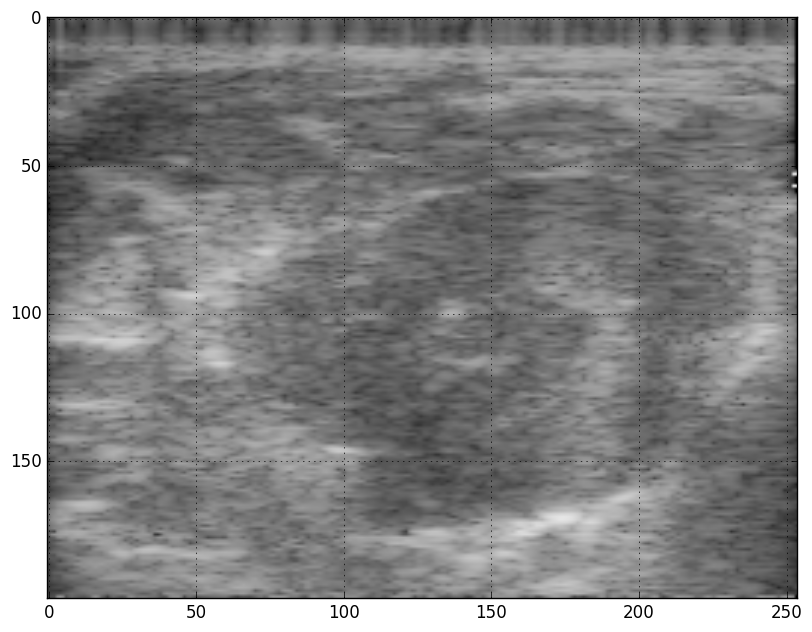

In [8]:
# display first slice
_ = plt.imshow(imInput[:, :, 0])

In [25]:
# show video using opencv
utils.cvShowVideo(utils.normalizeArray(imInput), 'Input Video', resizeAmount=2.0)

### Run phase estimation algorithm

In [9]:
# Parameters
algo_params = {
    
    'median_filter_size': 1,    
    
    'detrend_method': 'hp',    
    'hp_lamda': 200,  # needs to be tuned - controls smoothness trend/respiration signal
    
    'band_pass_bpm': [120.0, 840.0],
    
    'resp_phase_cutoff': 0.2,  # used 
}

print algo_params

algo = uspgs.USPGS(**algo_params)
algo.set_input(imInput, framesPerSec)
algo.process() 

ts = algo.get_frame_similarity_signal()

ts_resp = algo.get_respiration_signal()
ts_cardiac = algo.get_cardiac_signal()

ts_instaphase_resp = algo.get_respiratory_phase()
ts_instaphase_cardiac = algo.get_cardiac_phase()

period = algo.get_cardiac_cycle_duration()

{'band_pass_bpm': [120.0, 840.0], 'resp_phase_cutoff': 0.2, 'detrend_method': 'hp', 'hp_lamda': 200, 'median_filter_size': 1}
Input video size:  (197, 254, 1220)

>> Step-1: Suppressing noise ...


Noise suppression took 5.99 seconds

>> Step-2: Estimating instantaneous phase ...


Computing similarity using normalized correlation ...  took 0.972645998001 seconds
Chose frame 1029 as key frame
Estimated period = 8.03 frames
Estimated number of periods = 152.00
Frames with bad respiration influence = 40.57%

Phase estimation took 4.03 seconds

>> Done processing ... took a total of 10.02 seconds


### Investigate phase estimation

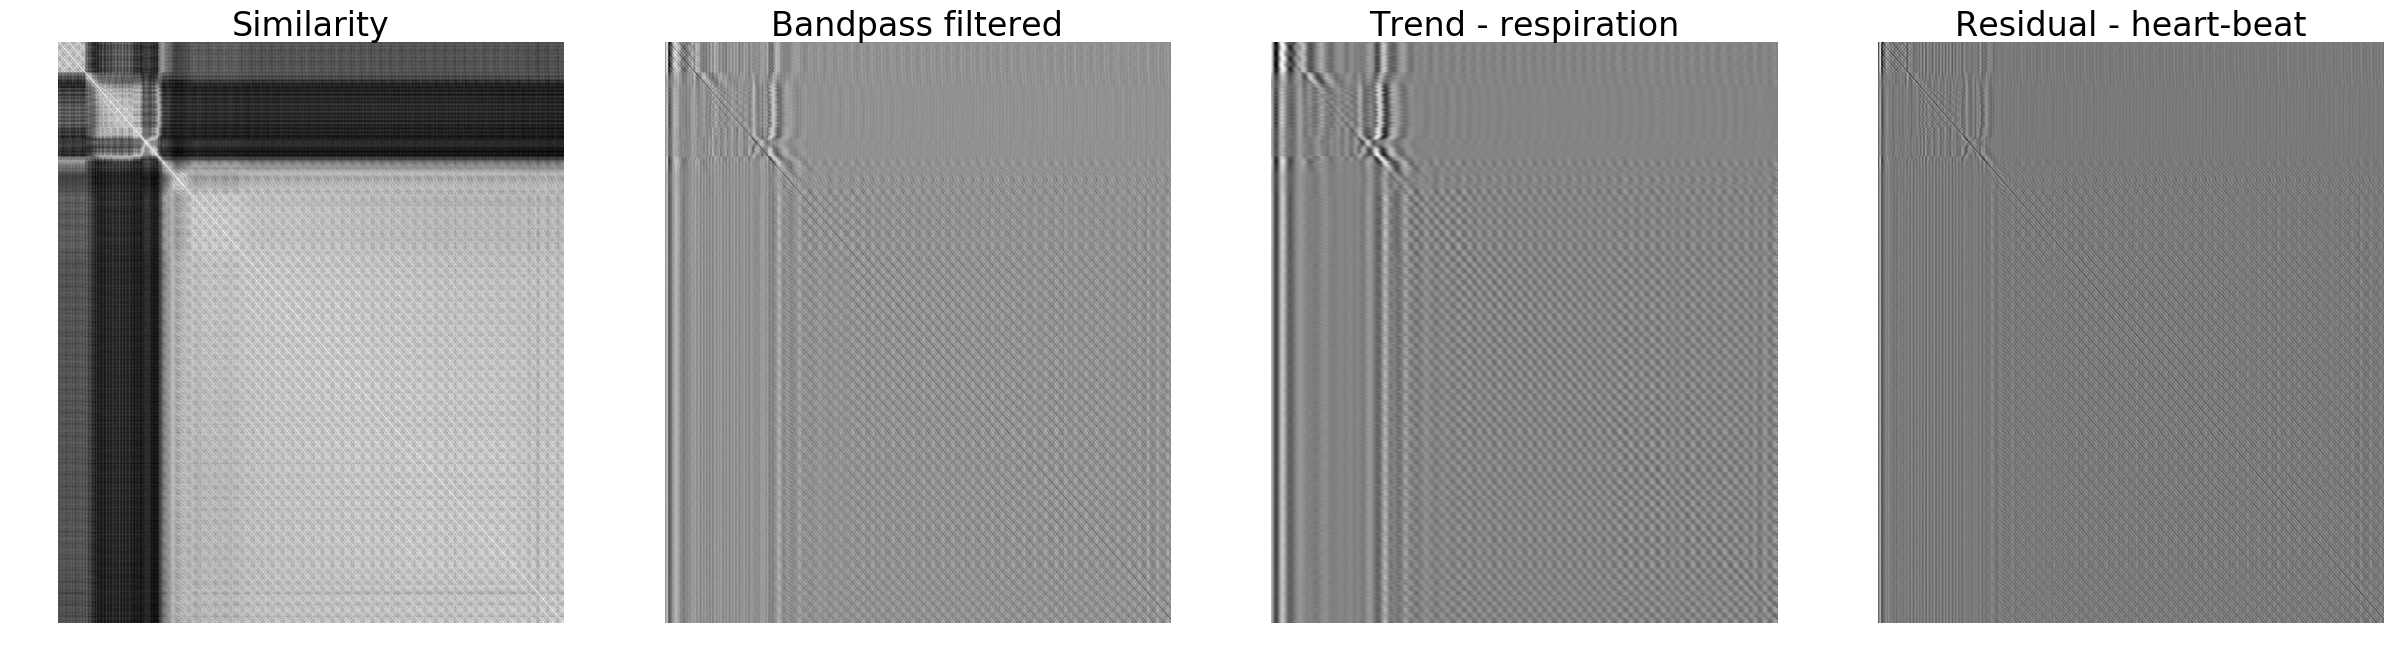

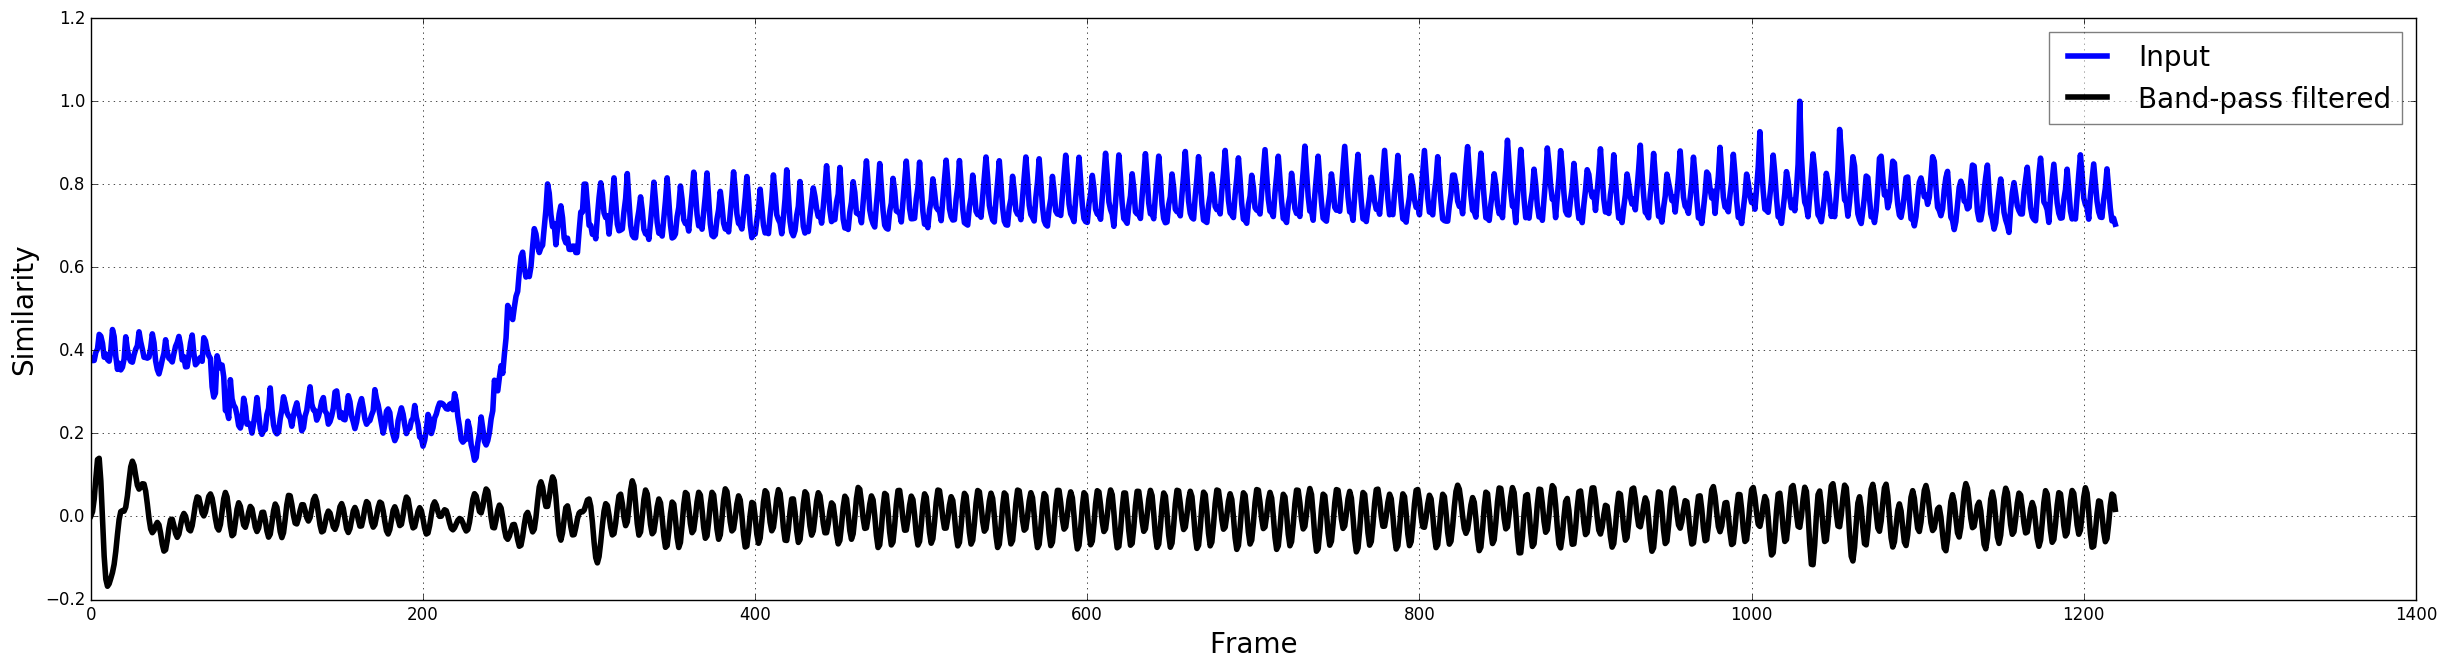

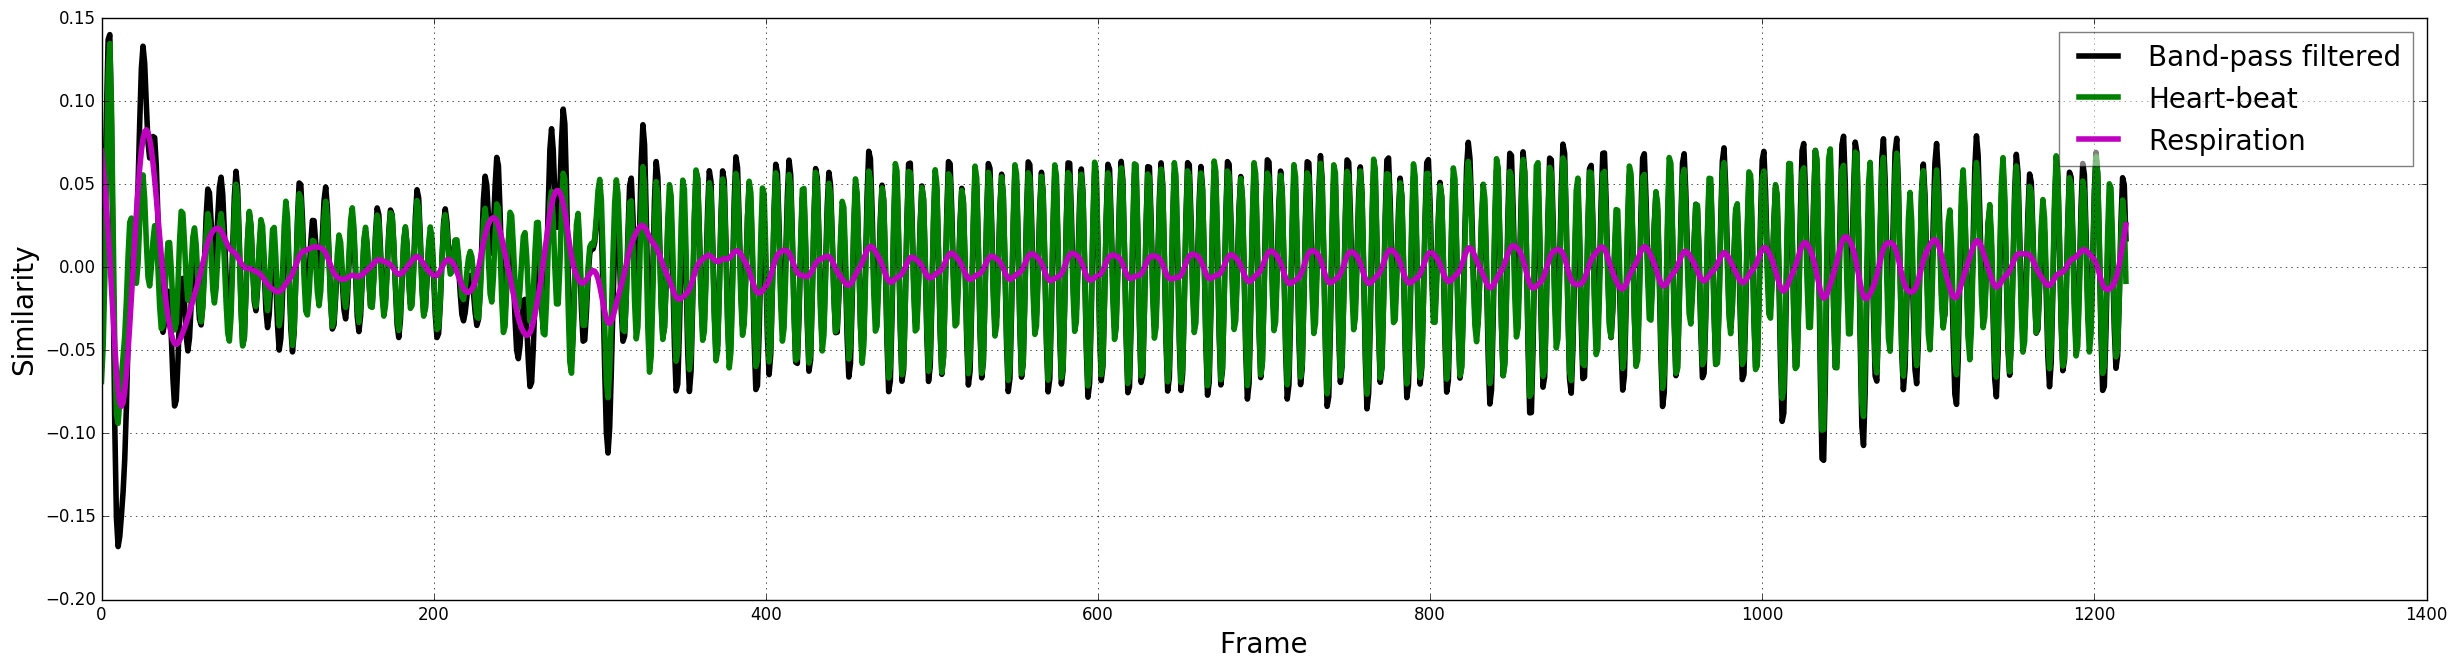

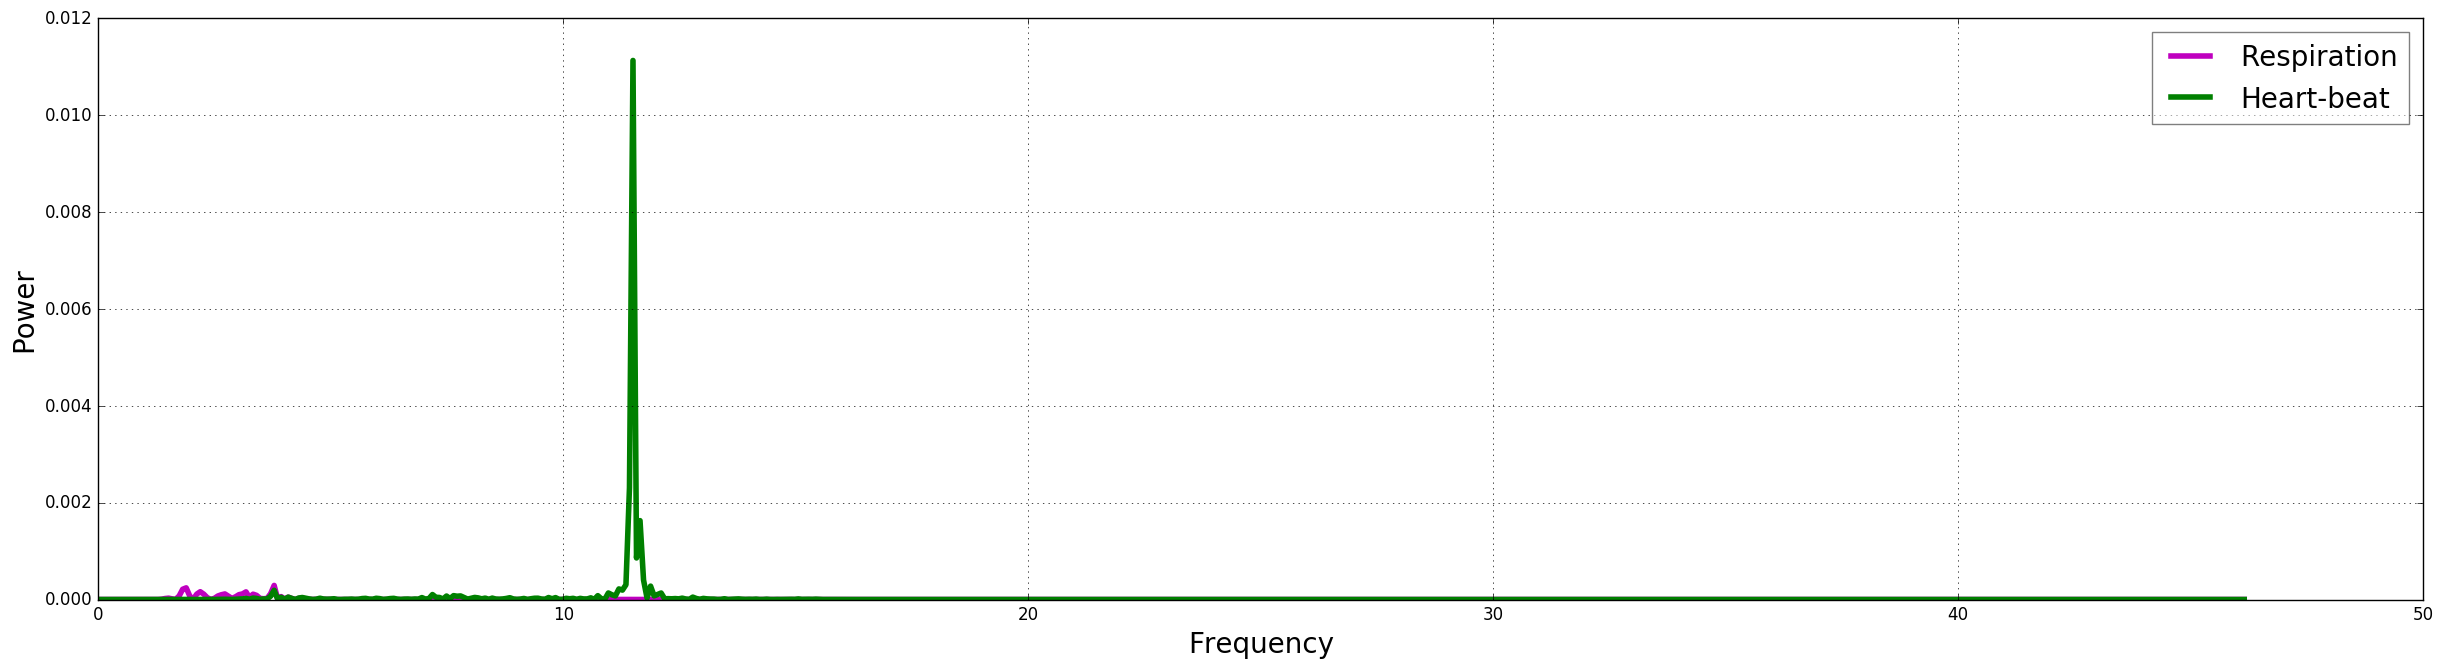

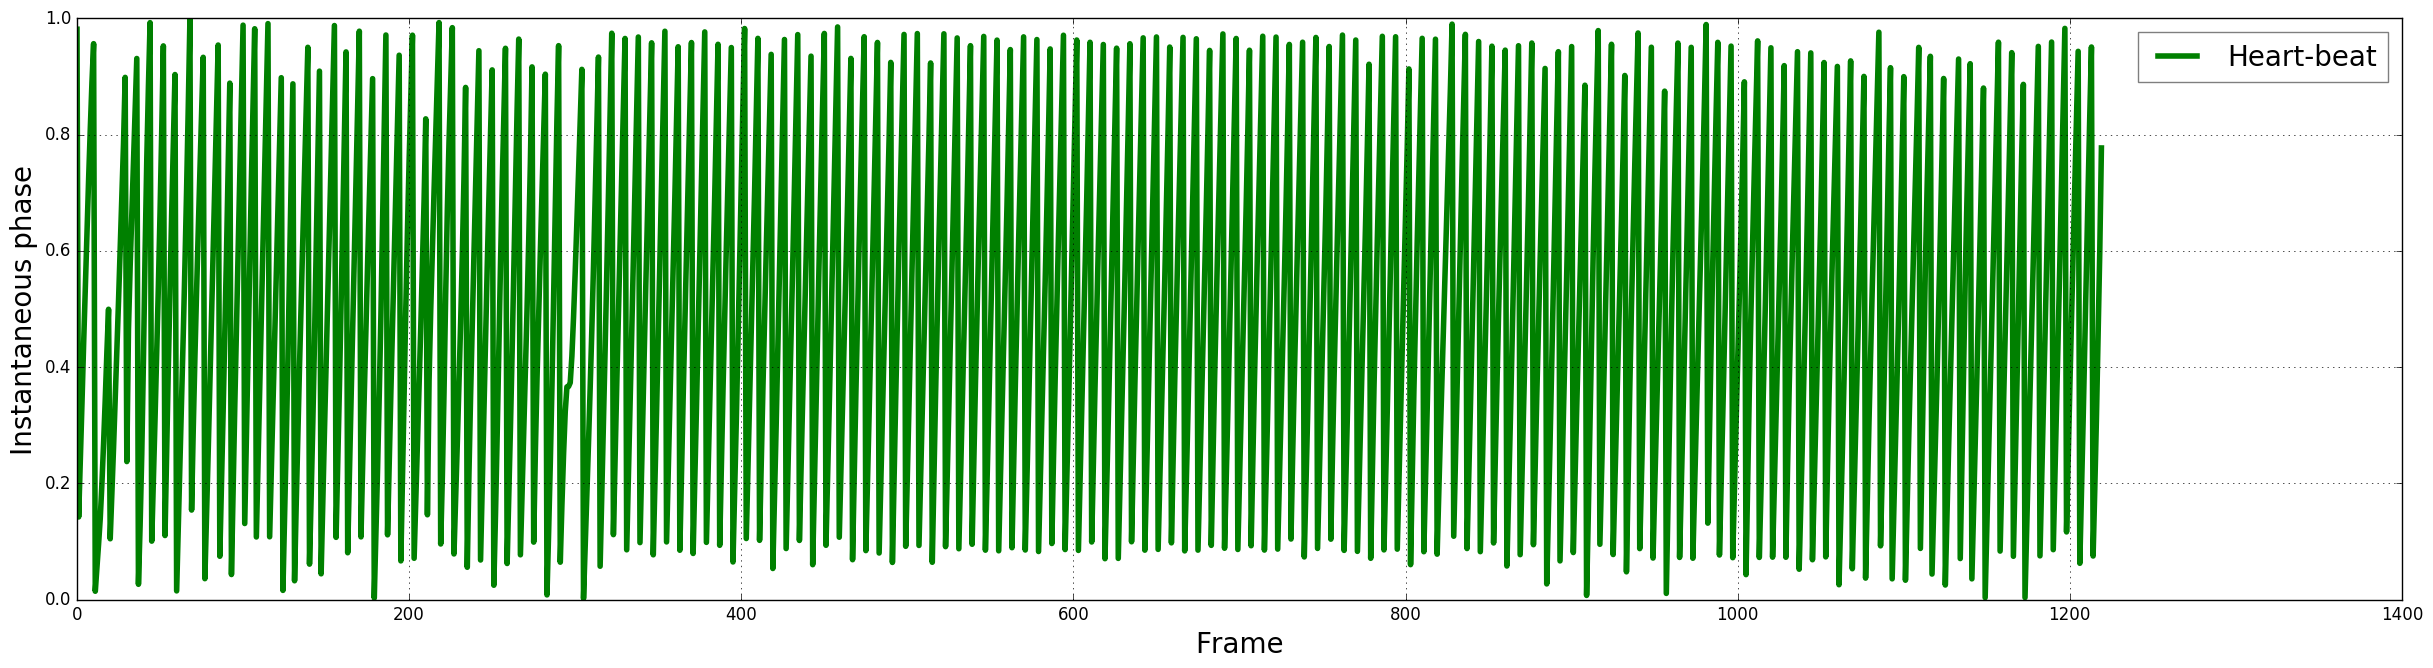

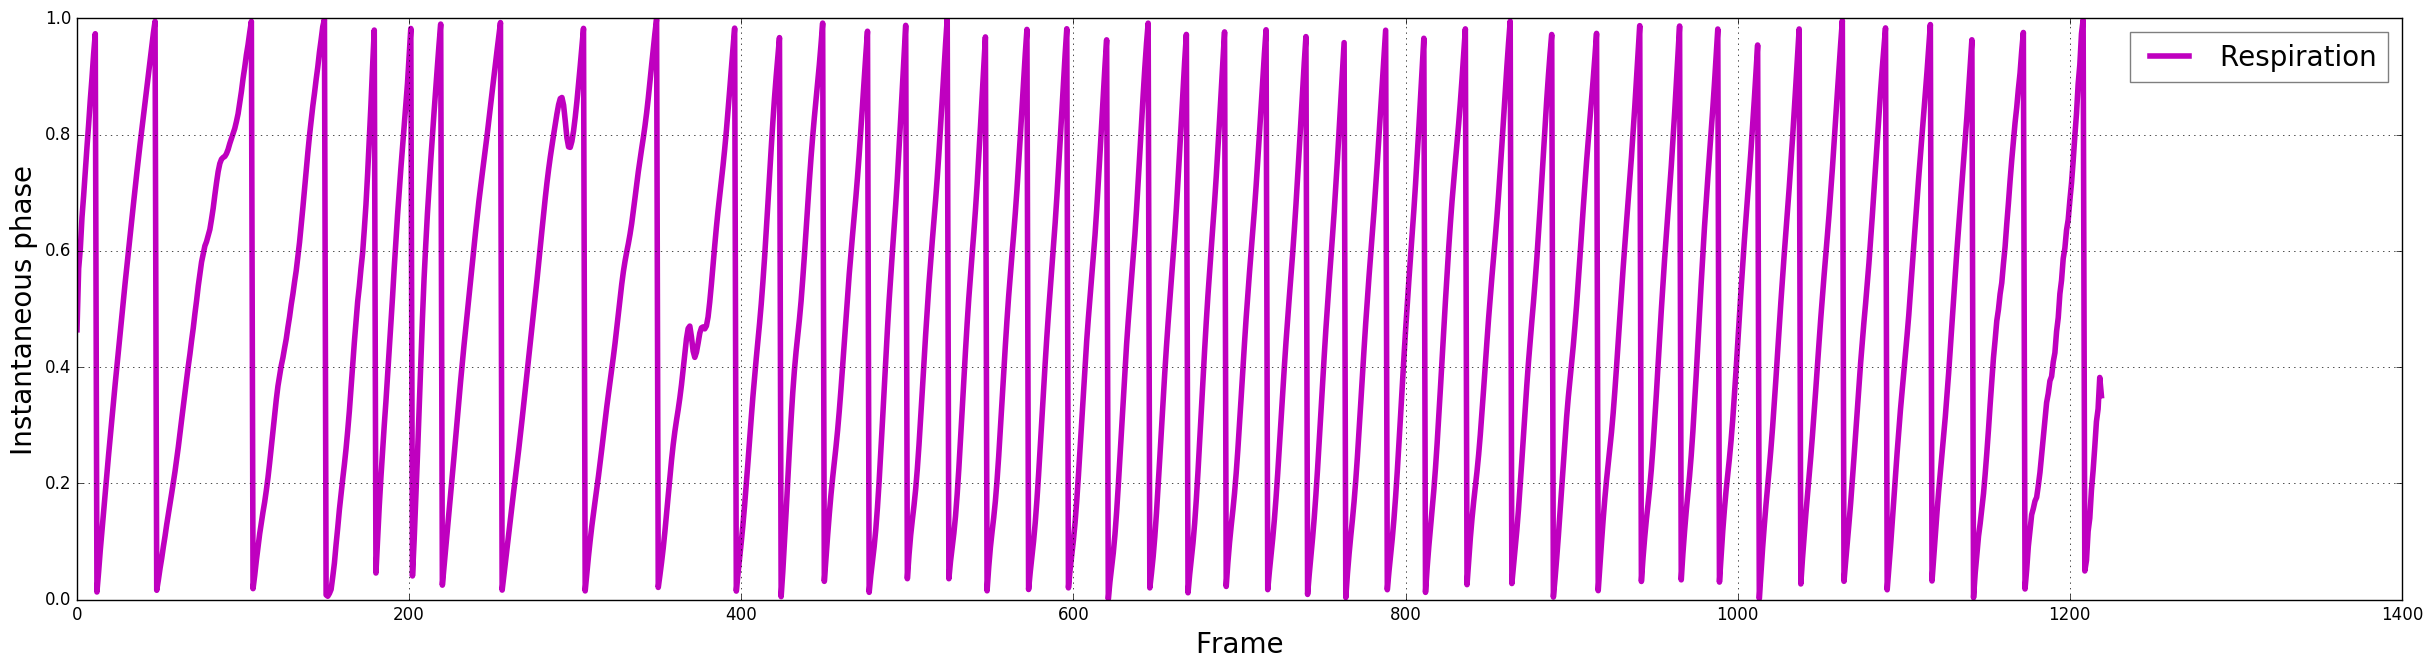

In [10]:
#
# plot the whole similarity landscape along with its trend and seasonal parts
#
fig, ax = plt.subplots(1, 4, sharey=True)

simMat = algo.simMat_
simMat_Bpass = algo.simMat_Bpass_
simMat_Trend = algo.simMat_Trend_
simMat_Seasonal = algo.simMat_Seasonal_

ax[0].imshow(simMat)
ax[0].set_title('Similarity')
ax[0].axis('off')
ax[0].axis('tight')

ax[1].imshow(simMat_Bpass)
ax[1].set_title('Bandpass filtered')
ax[1].axis('off')
ax[1].axis('tight')

ax[2].imshow(simMat_Trend)
ax[2].set_title('Trend - respiration')
ax[2].axis('off')
ax[2].axis('tight')

ax[3].imshow(simMat_Seasonal)
ax[3].set_title('Residual - heart-beat')
ax[3].axis('off')
ax[3].axis('tight')

# Show decoupling of respiration and cardiac signals
plt.figure()

plt.plot(ts, 'b-', label='Input')
plt.plot(algo.ts_bpass_, 'k-', label='Band-pass filtered')
plt.xlabel('Frame')
plt.ylabel('Similarity')
plt.legend(framealpha=0.5)

plt.figure()

plt.plot(algo.ts_bpass_, 'k-', label='Band-pass filtered')
plt.plot(ts_cardiac, 'g-', label='Heart-beat')
plt.plot(ts_resp, 'm-', label='Respiration')
plt.xlabel('Frame')
plt.ylabel('Similarity')
plt.legend(framealpha=0.5)

# show frequency spectrum of trend/respiration and residual/cardiac components
freq_resp, power_resp = scipy.signal.periodogram(ts_resp, fs=framesPerSec)
freq_cardiac, power_cardiac = scipy.signal.periodogram(ts_cardiac, fs=framesPerSec)

plt.figure()
plt.plot(freq_resp, power_resp, 'm-', label='Respiration')
plt.plot(freq_cardiac, power_cardiac, 'g-', label='Heart-beat')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(framealpha=0.5)

# show estimate instantaneous phase of heart-beat and respiration
plt.figure()
plt.plot(ts_instaphase_cardiac, 'g-', label='Heart-beat')
plt.xlabel('Frame')
plt.ylabel('Instantaneous phase')
plt.legend(framealpha=0.5)

plt.figure()
plt.plot(ts_instaphase_resp, 'm-', label='Respiration')
plt.xlabel('Frame')
plt.ylabel('Instantaneous phase')
plt.legend(framealpha=0.5)

### Investigate respiratory gating

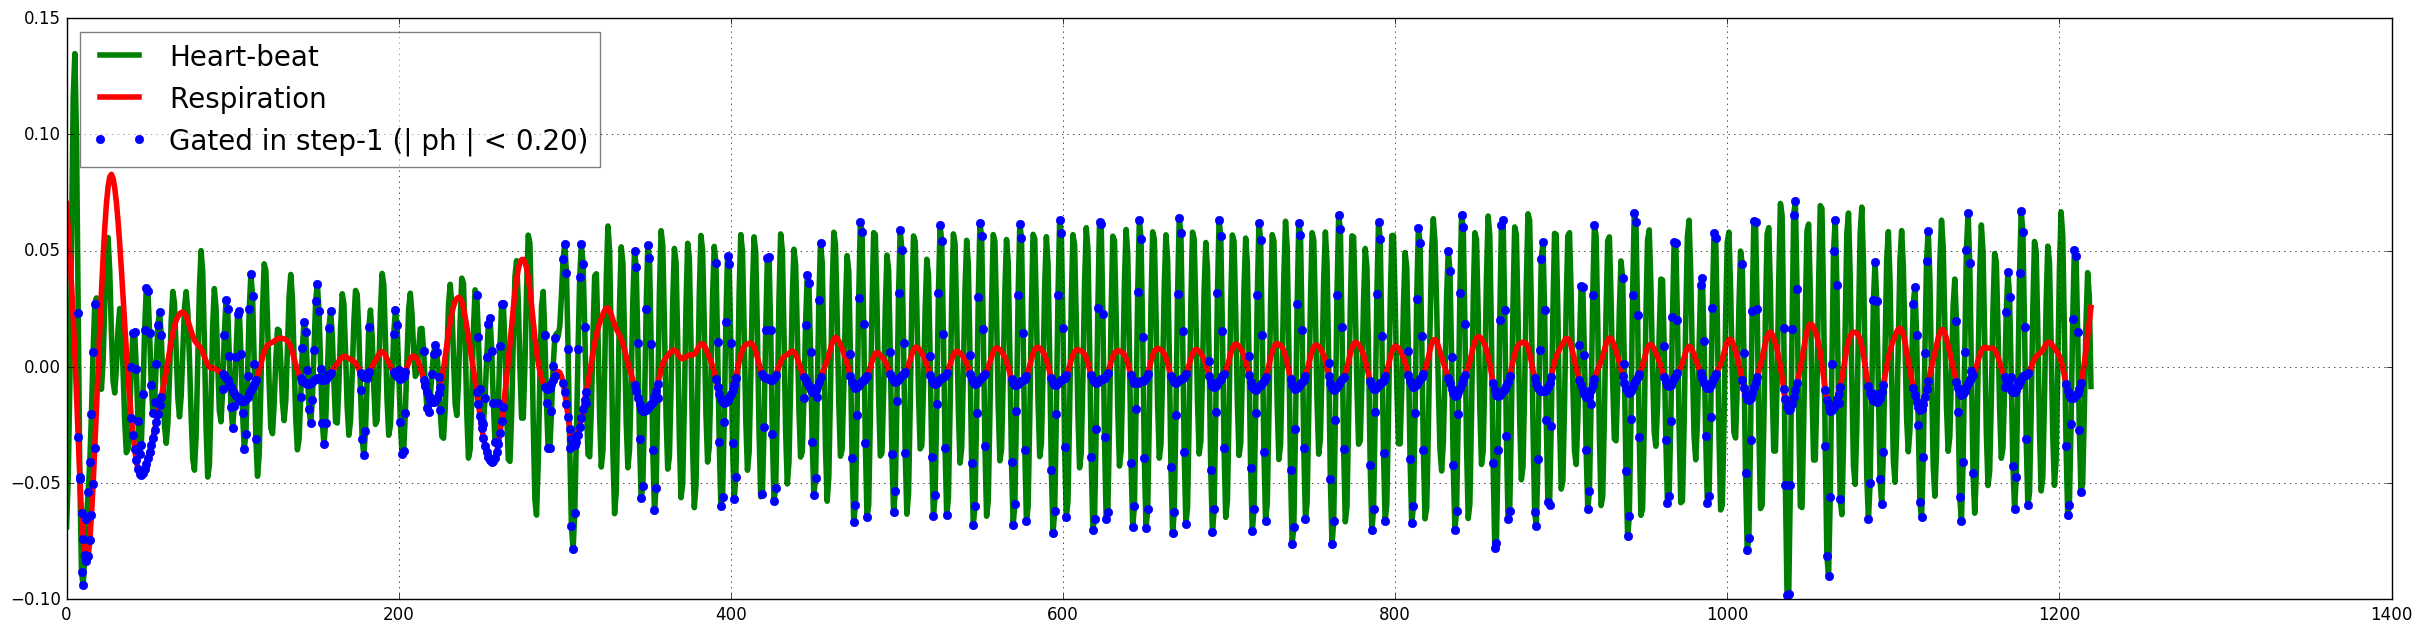

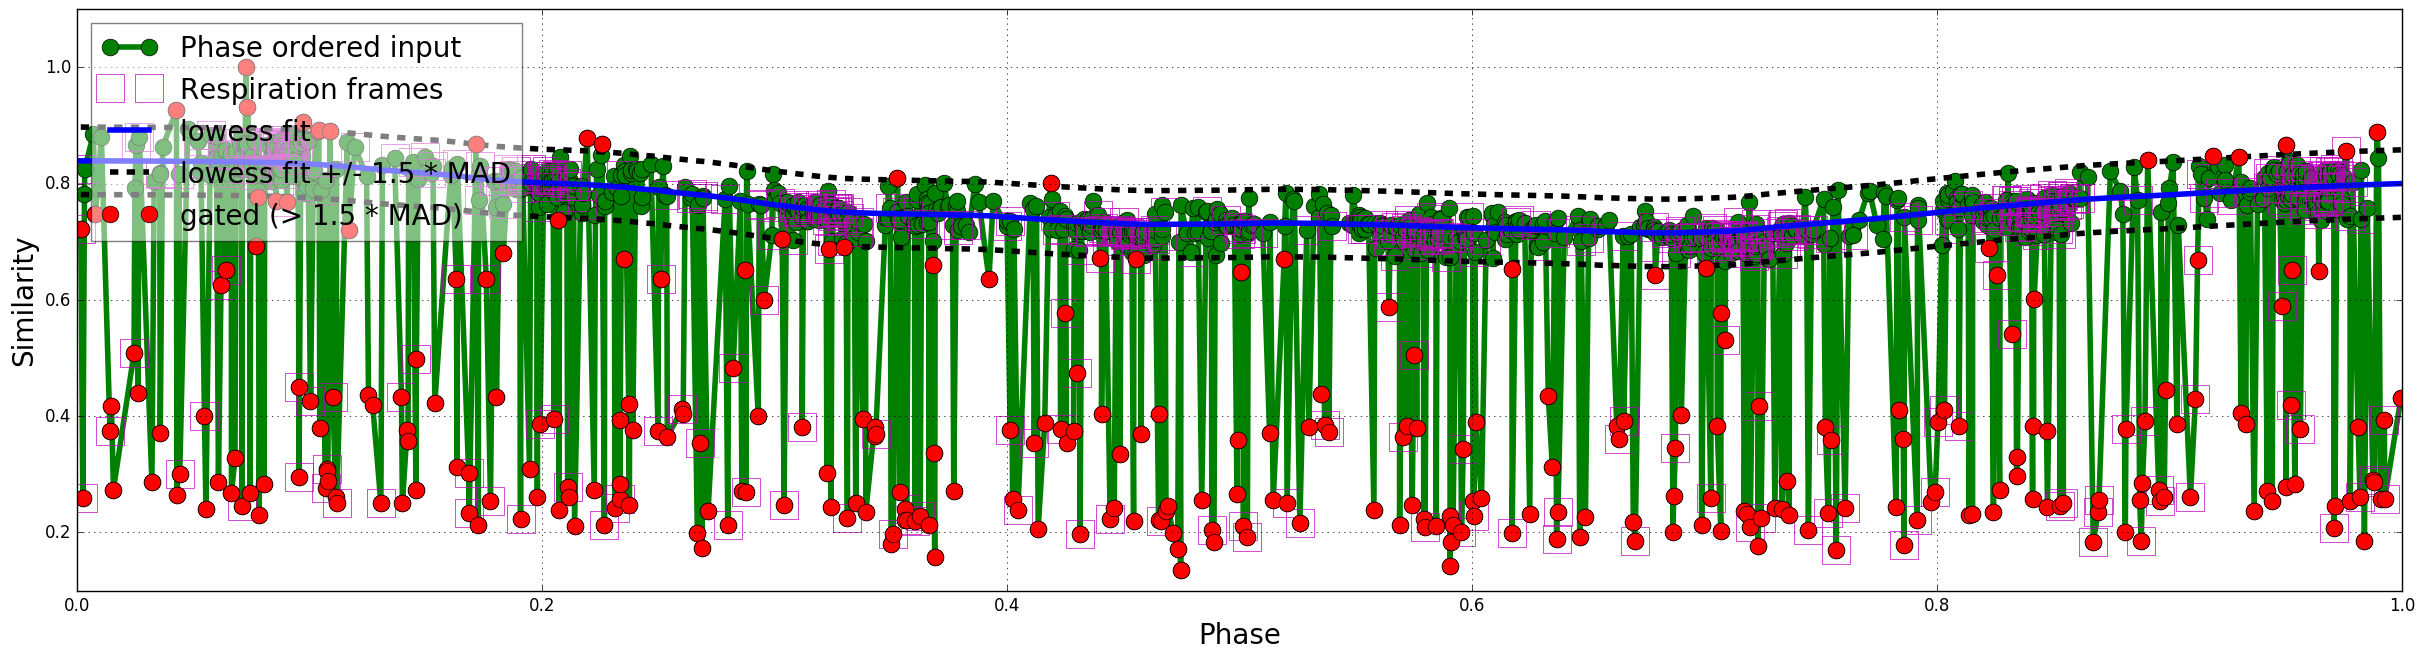

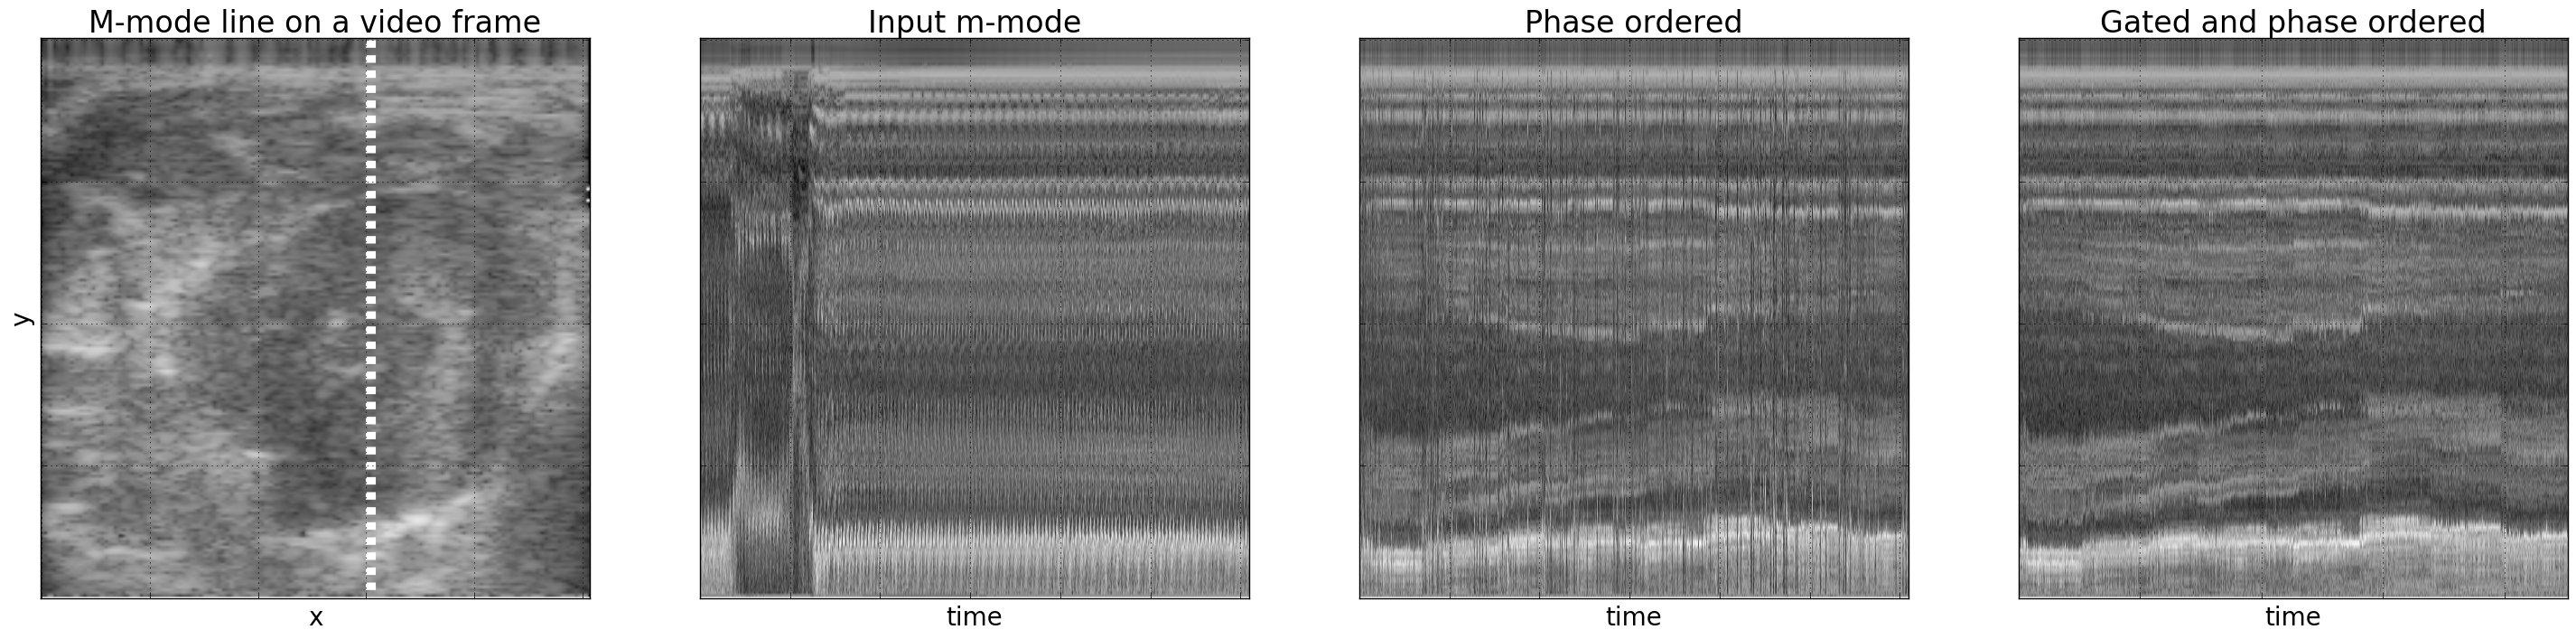

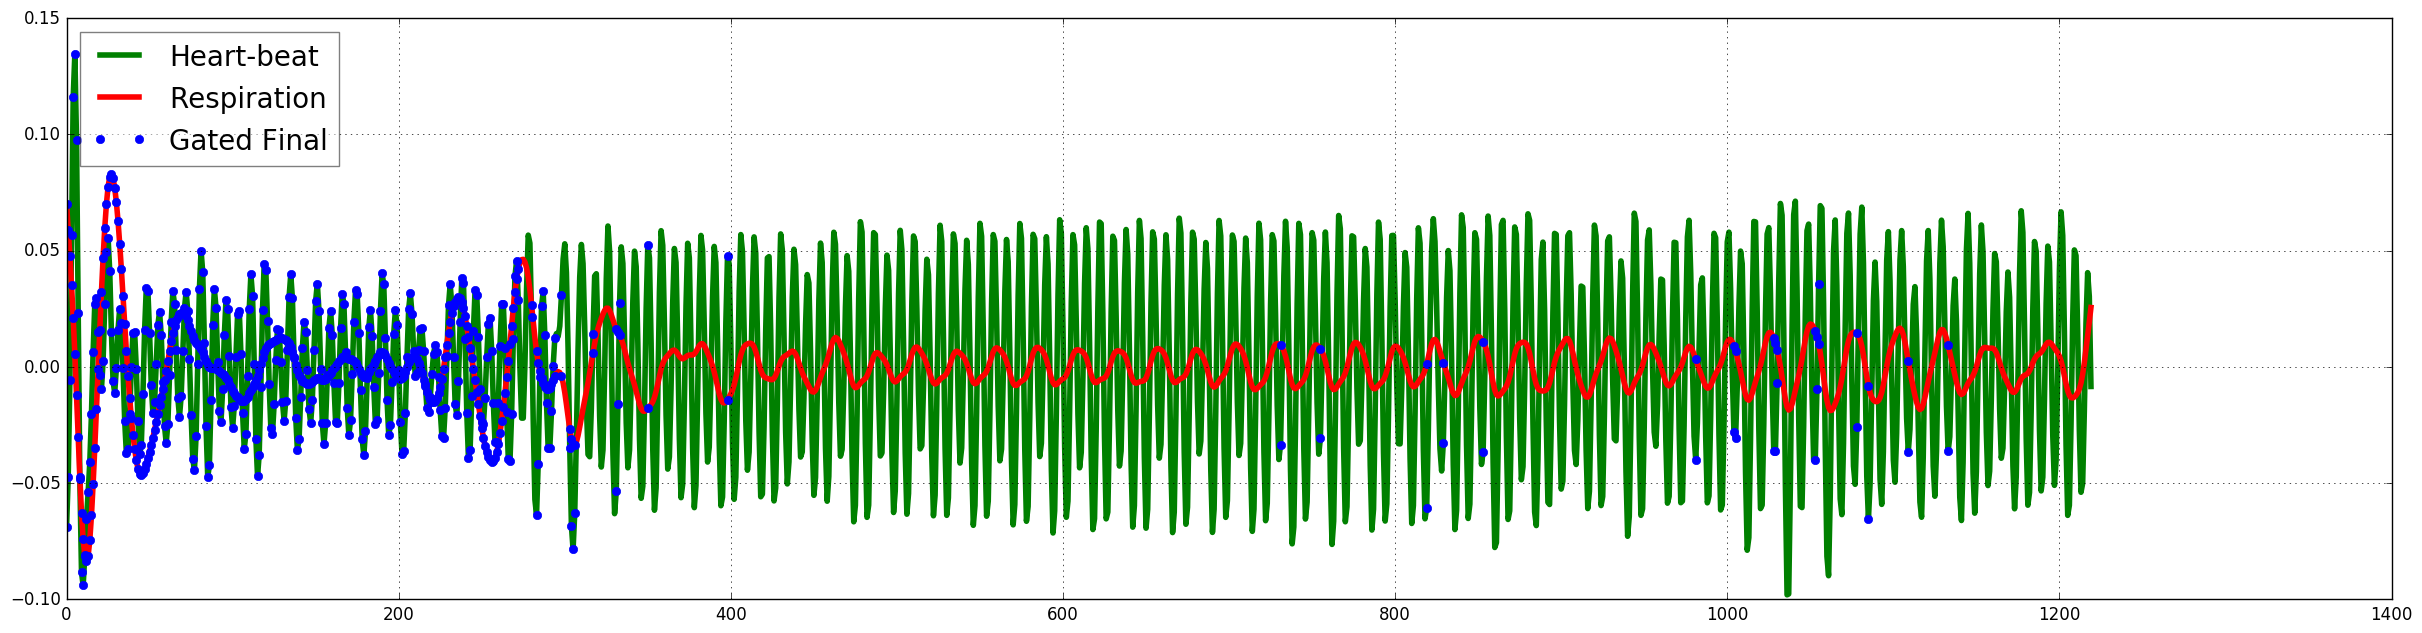

In [26]:
mmode_pos = int(0.6 * imInput.shape[1])
image_aspect = np.float(imInput.shape[1]) / imInput.shape[0]

# order m-mode frames by estimated cardiac phase before and after gating
phaseord_est = np.argsort(ts_instaphase_cardiac)
imInput_phaseord = imInput[:,:,phaseord_est]

k_mad = 1.5
resp_ind = algo.resp_ind_
fid_lowess = algo.fid_lowess_
sim_lowess_reg = algo.sim_lowess_reg_

ph_resp = ts_instaphase_cardiac[resp_ind]
sim_resp = simMat[fid_lowess, resp_ind]

ph_org = ts_instaphase_cardiac[phaseord_est]
sim_org = simMat[fid_lowess, phaseord_est]

sim_lowess = sim_lowess_reg.predict(ph_org)

gated_ind = phaseord_est[np.argwhere(abs(sim_org - sim_lowess) > k_mad * sim_lowess_reg.residual_mad())]
phaseord_est_gated = [fid for fid in phaseord_est if fid not in gated_ind]
imInput_phaseord_gated = imInput[: , :, phaseord_est_gated]

ph_gated = ts_instaphase_cardiac[gated_ind]
sim_gated = simMat[fid_lowess, gated_ind]

# visualize frames thrownout in the first step of respiratory gating
plt.figure()
plt.plot(ts_cardiac, 'g-', label='Heart-beat')
plt.plot(ts_resp, 'r-', label='Respiration')
plt.plot(resp_ind, ts_cardiac[resp_ind], 'b.', label='Gated in step-1 (| ph | < %.2f)' % algo.resp_phase_cutoff)
plt.plot(resp_ind, ts_resp[resp_ind], 'b.')
plt.legend(framealpha=0.5, loc='upper left');

# visualize lowess fit and gated frames
plt.figure()

plt.plot(ph_org, sim_org, 'g-o', label='Phase ordered input')
plt.plot(ph_resp, sim_resp, 'ms', label='Respiration frames',
         fillstyle='none', markersize=20)
plt.plot(ph_org, sim_lowess, 'b-', label='lowess fit')

plt.plot(ph_org, sim_lowess + k_mad * sim_lowess_reg.residual_mad(), 'k--')
plt.plot(ph_org, sim_lowess - k_mad * sim_lowess_reg.residual_mad(), 'k--', label='lowess fit +/- %.1f * MAD' % k_mad)

plt.plot(ph_gated, sim_gated, 'ro', label='gated (> %.1f * MAD)' % k_mad)

plt.xlabel('Phase')
plt.ylabel('Similarity')
plt.legend(loc='upper left', framealpha=0.5)

# show m-mode frames ordered by estimated phase
fig, ax = plt.subplots(1, 4, sharey=True, figsize=(8 * image_aspect * 3.5, 8))

ax[0].imshow(imInput[:, :, 0])
ax[0].plot([mmode_pos, mmode_pos], [0, imInput.shape[0]], 'w--', linewidth=8)
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('M-mode line on a video frame')
# ax[0].axis('off')
ax[0].axis('tight')

ax[1].imshow(imInput[:, mmode_pos, :])
ax[1].set_xlabel('time')
ax[1].set_title('Input m-mode')
# ax[1].axis('off')
ax[1].axis('tight')

ax[2].imshow(imInput_phaseord[:, mmode_pos, :])
ax[2].set_xlabel('time')
ax[2].set_title('Phase ordered')
# ax[2].axis('off')
ax[2].axis('tight')

ax[3].imshow(imInput_phaseord_gated[:, mmode_pos, :])
ax[3].set_xlabel('time')
ax[3].set_title('Gated and phase ordered')
# ax[3].axis('off')
ax[3].axis('tight')

_ = plt.setp([a.get_xticklabels() for a in ax], visible=False)
_ = plt.setp([a.get_yticklabels() for a in ax], visible=False)

# show final gated frames
plt.figure()
plt.plot(ts_cardiac, 'g-', label='Heart-beat')
plt.plot(ts_resp, 'r-', label='Respiration')
plt.plot(gated_ind, ts_cardiac[gated_ind], 'b.', label='Gated Final')
plt.plot(gated_ind, ts_resp[gated_ind], 'b.')
plt.legend(framealpha=0.5, loc='upper left');

### Generate and visualize single cycle video at desired resolution

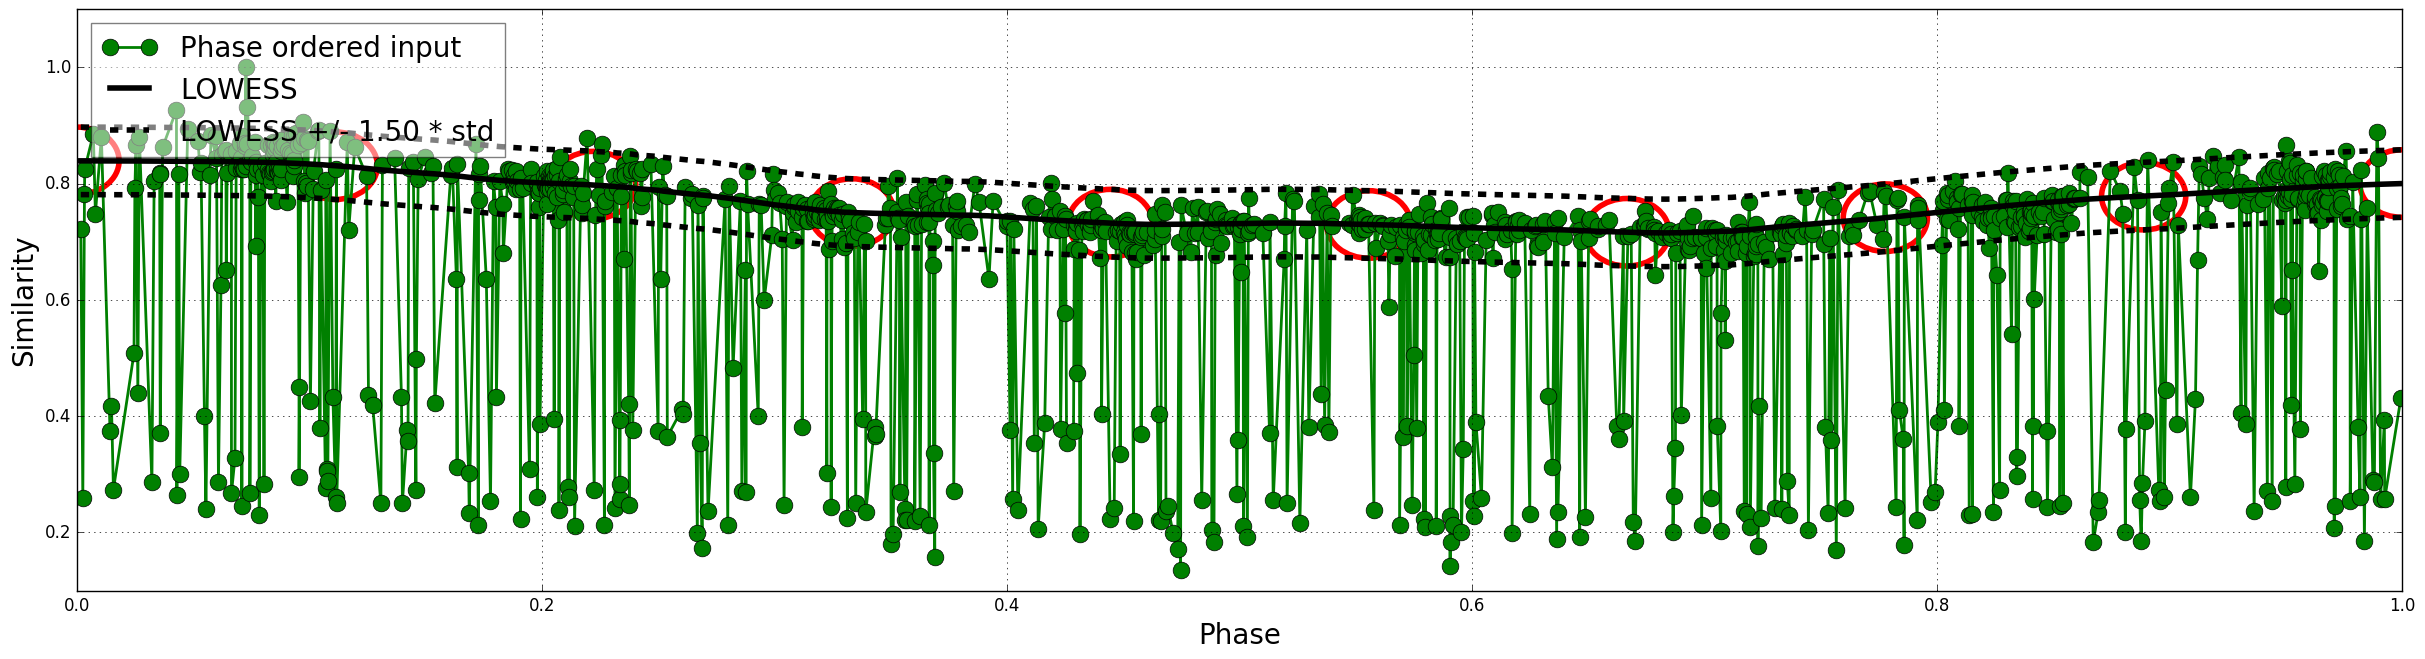

In [21]:
# tweak and visualize sigma factors for kernel regression
kPhase = 0.1
kSim = 1.5
mag = 1

synthPhaseVals = np.linspace(0, 1, 10)

phaseord_est = np.argsort(algo.ts_instaphase_nmzd_)

ph_org = algo.ts_instaphase_nmzd_[phaseord_est]
sim_org = algo.ts_[phaseord_est]

sim_lowess = algo.sim_lowess_reg_.predict(ph_org)
sim_mad = algo.sim_lowess_reg_.residual_mad()

pdiff = uspgs.phaseDiff(algo.ts_instaphase_nmzd_)
pstd = sm.robust.scale.mad(pdiff, center=0)

synthPhaseSims = algo.sim_lowess_reg_.predict(synthPhaseVals)

wPhase = 2 * kPhase * pstd
wSim = 2 * kSim * sim_mad

plt.plot(ph_org, sim_org, 'g-o', linewidth=linewidth/2, label='Phase ordered input')
plt.plot(ph_org, sim_lowess, 'k-', label='LOWESS')

plt.plot(ph_org, sim_lowess + kSim * sim_mad, 'k--')
plt.plot(ph_org, sim_lowess - kSim * sim_mad, 'k--', label='LOWESS +/- %.2f * std' % kSim)

for cur_ph, cur_sim in zip(synthPhaseVals, synthPhaseSims):
    
    c = [cur_ph, cur_sim]
    
    cur_el = mpatches.Ellipse(xy=c, width=wPhase, height=wSim, fill=False, color='r', linewidth=linewidth)
    plt.gca().add_patch(cur_el)

plt.xlabel('Phase')
plt.ylabel('Similarity')
plt.legend(loc='upper left', framealpha=0.5)

In [16]:
# set parmeters
upsampleAmount = 8
sigmaPhaseFactor = kPhase
sigmaSimilarityFactor = kSim

mparams = uspgs.config_framegen_using_kernel_regression(
    sigmaPhaseFactor=sigmaPhaseFactor, 
    sigmaSimilarityFactor=sigmaSimilarityFactor, 
    stochastic=False
)

numOutFrames = np.rint(upsampleAmount * period)        

imOnePeriodVideo = algo.generate_single_cycle_video(numOutFrames, imInput=imInput, method=mparams)

print imOnePeriodVideo.shape

01% 03% 04% 06% 07% 09% 10% 12% 14% 15% 17% 18% 20% 21% 23% 25% 26% 28% 29% 31% 32% 34% 35% 37% 39% 40% 42% 43% 45% 46% 48% 50% 51% 53% 54% 56% 57% 59% 60% 62% 64% 65% 67% 68% 70% 71% 73% 75% 76% 78% 79% 81% 82% 84% 85% 87% 89% 90% 92% 93% 95% 96% 98% 

(197, 254, 64)


In [17]:
# show video using opencv
utils.cvShowVideo(utils.normalizeArray(imOnePeriodVideo), 'Input Video Upsampled', resizeAmount=2.0)

#### Visually check images at and between cardiac phase minima where cycle begin/end

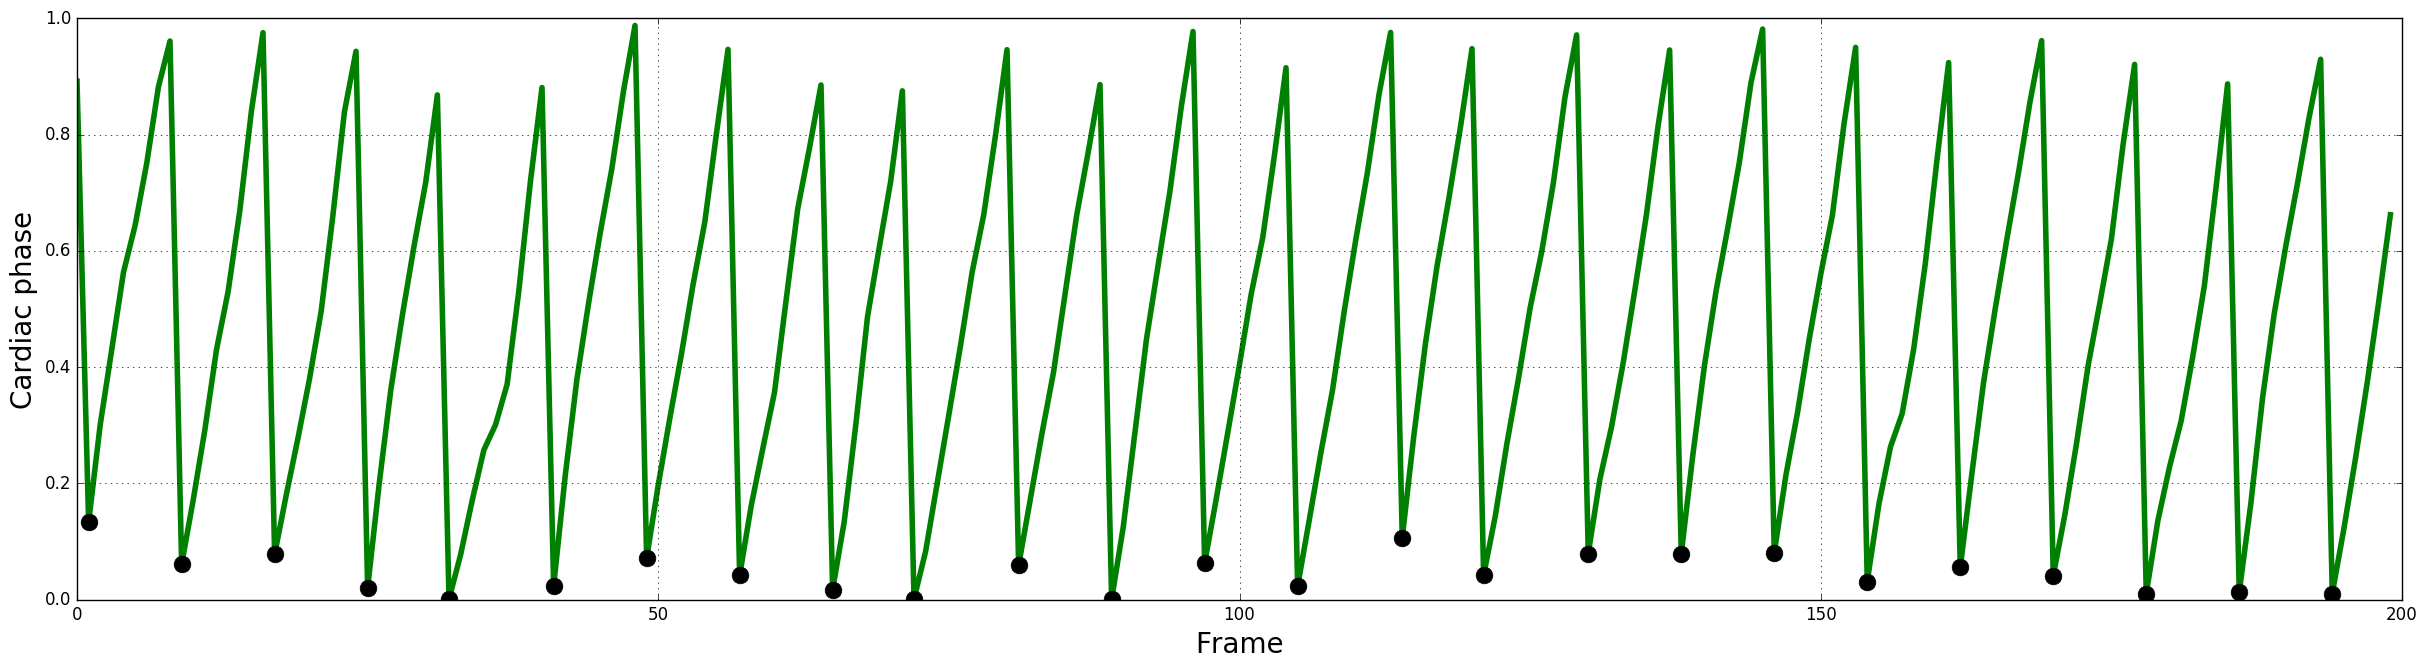

In [176]:
# detect cardiac phase valley points
ts_instaphase_cardiac_vloc = detect_peaks(ts_instaphase_cardiac, mpd=algo.period_ * 0.65, valley=True, show=False)

plt.plot(ts_instaphase_cardiac, 'g-', label='Cardiac phase')
plt.plot(ts_instaphase_cardiac_vloc, ts_instaphase_cardiac[ts_instaphase_cardiac_vloc], 'ko', 
         label='Cardiac phase minima')

plt.ylabel('Cardiac phase')
plt.xlabel('Frame')

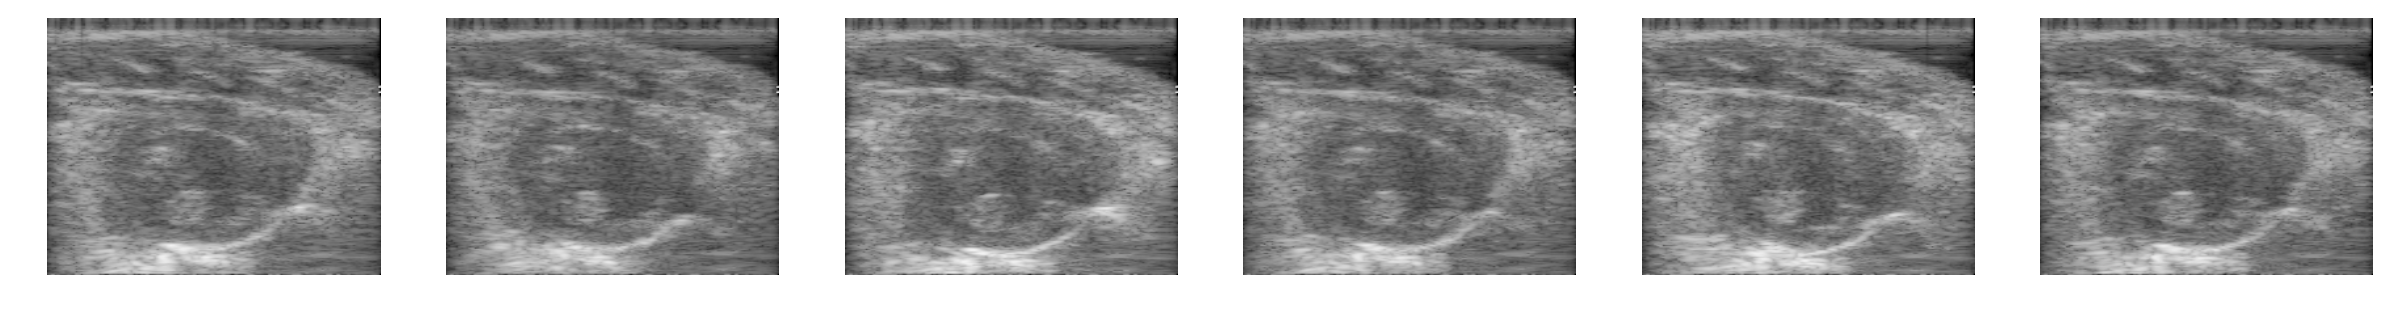

In [177]:
# visualize and verify if frames at cardiac phase minima look similar
num_minima_to_disp = 6

for i in range(num_minima_to_disp):
    
    plt.subplot(1, num_minima_to_disp, i+1)
    plt.imshow(imInput[:, :, ts_instaphase_cardiac_vloc[i]])
    plt.axis('off')    

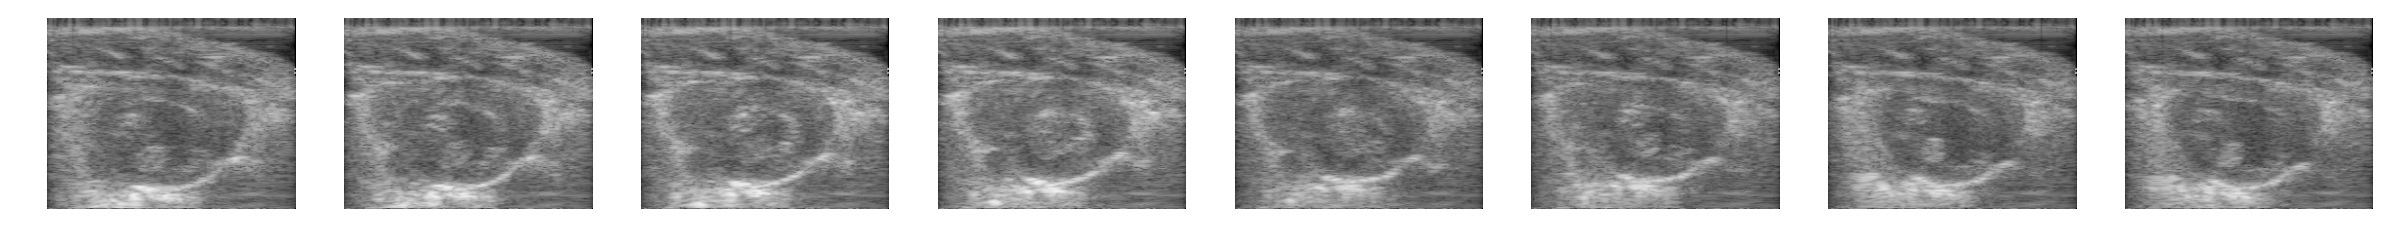

In [178]:
# visualize frames between two cardiac phase minima
pid = 0

f_insta = range(ts_instaphase_cardiac_vloc[pid], ts_instaphase_cardiac_vloc[pid+1])

for i in range(len(f_insta)):
    
    plt.subplot(1, len(f_insta), i+1)
    plt.imshow(imInput[:, :, f_insta[i]])
    plt.axis('off')    